In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:39 - loss: 0.1005 - STD: 1.2879e-04 - MAE: 0.3059

 4/64 [>.............................] - ETA: 1s - loss: 0.0403 - STD: 4.2393e-04 - MAE: 0.1533  

 5/64 [=>............................] - ETA: 2s - loss: 0.0389 - STD: 3.8347e-04 - MAE: 0.1514

 6/64 [=>............................] - ETA: 2s - loss: 0.0385 - STD: 3.4676e-04 - MAE: 0.1517

 7/64 [==>...........................] - ETA: 2s - loss: 0.0381 - STD: 3.1711e-04 - MAE: 0.1517

 8/64 [==>...........................] - ETA: 2s - loss: 0.0375 - STD: 2.9537e-04 - MAE: 0.1509

 9/64 [===>..........................] - ETA: 2s - loss: 0.0368 - STD: 2.8157e-04 - MAE: 0.1491

10/64 [===>..........................] - ETA: 2s - loss: 0.0359 - STD: 2.7447e-04 - MAE: 0.1463

11/64 [====>.........................] - ETA: 2s - loss: 0.0347 - STD: 2.7326e-04 - MAE: 0.1422

12/64 [====>.........................] - ETA: 2s - loss: 0.0332 - STD: 2.7619e-04 - MAE: 0.1368

13/64 [=====>........................] - ETA: 2s - loss: 0.0317 - STD: 2.8289e-04 - MAE: 0.1310

14/64 [=====>........................] - ETA: 2s - loss: 0.0304 - STD: 2.9173e-04 - MAE: 0.1263

15/64 [======>.......................] - ETA: 2s - loss: 0.0293 - STD: 3.0182e-04 - MAE: 0.1232

16/64 [======>.......................] - ETA: 2s - loss: 0.0283 - STD: 3.1231e-04 - MAE: 0.1217

17/64 [======>.......................] - ETA: 2s - loss: 0.0277 - STD: 3.2280e-04 - MAE: 0.1212

18/64 [=======>......................] - ETA: 2s - loss: 0.0272 - STD: 3.3314e-04 - MAE: 0.1212

19/64 [=======>......................] - ETA: 2s - loss: 0.0267 - STD: 3.4269e-04 - MAE: 0.1211

20/64 [========>.....................] - ETA: 3s - loss: 0.0266 - STD: 3.5113e-04 - MAE: 0.1207

23/64 [=========>....................] - ETA: 3s - loss: 0.0249 - STD: 3.7509e-04 - MAE: 0.1167

25/64 [==========>...................] - ETA: 3s - loss: 0.0239 - STD: 3.8679e-04 - MAE: 0.1125

26/64 [===========>..................] - ETA: 2s - loss: 0.0235 - STD: 3.9207e-04 - MAE: 0.1106

27/64 [===========>..................] - ETA: 2s - loss: 0.0231 - STD: 3.9674e-04 - MAE: 0.1087

28/64 [============>.................] - ETA: 2s - loss: 0.0228 - STD: 4.0156e-04 - MAE: 0.1070

29/64 [============>.................] - ETA: 2s - loss: 0.0225 - STD: 4.0641e-04 - MAE: 0.1055

30/64 [=============>................] - ETA: 2s - loss: 0.0222 - STD: 4.1178e-04 - MAE: 0.1040

31/64 [=============>................] - ETA: 2s - loss: 0.0220 - STD: 4.1775e-04 - MAE: 0.1026

32/64 [==============>...............] - ETA: 2s - loss: 0.0217 - STD: 4.2474e-04 - MAE: 0.1013

33/64 [==============>...............] - ETA: 2s - loss: 0.0214 - STD: 4.3234e-04 - MAE: 0.1001

34/64 [==============>...............] - ETA: 2s - loss: 0.0211 - STD: 4.4094e-04 - MAE: 0.0990

35/64 [===============>..............] - ETA: 2s - loss: 0.0209 - STD: 4.5050e-04 - MAE: 0.0981

36/64 [===============>..............] - ETA: 2s - loss: 0.0207 - STD: 4.6075e-04 - MAE: 0.0973

37/64 [================>.............] - ETA: 2s - loss: 0.0204 - STD: 4.7214e-04 - MAE: 0.0968

38/64 [================>.............] - ETA: 1s - loss: 0.0203 - STD: 4.8407e-04 - MAE: 0.0964

39/64 [=================>............] - ETA: 1s - loss: 0.0201 - STD: 4.9669e-04 - MAE: 0.0961

40/64 [=================>............] - ETA: 1s - loss: 0.0199 - STD: 5.0941e-04 - MAE: 0.0958

41/64 [==================>...........] - ETA: 1s - loss: 0.0197 - STD: 5.2273e-04 - MAE: 0.0955

42/64 [==================>...........] - ETA: 1s - loss: 0.0196 - STD: 5.3657e-04 - MAE: 0.0952

43/64 [===================>..........] - ETA: 1s - loss: 0.0194 - STD: 5.5049e-04 - MAE: 0.0948

44/64 [===================>..........] - ETA: 1s - loss: 0.0192 - STD: 5.6452e-04 - MAE: 0.0943

45/64 [====================>.........] - ETA: 1s - loss: 0.0191 - STD: 5.7872e-04 - MAE: 0.0938

46/64 [====================>.........] - ETA: 1s - loss: 0.0189 - STD: 5.9305e-04 - MAE: 0.0932

47/64 [=====================>........] - ETA: 1s - loss: 0.0188 - STD: 6.0756e-04 - MAE: 0.0926

48/64 [=====================>........] - ETA: 1s - loss: 0.0187 - STD: 6.2277e-04 - MAE: 0.0921

49/64 [=====================>........] - ETA: 1s - loss: 0.0185 - STD: 6.3844e-04 - MAE: 0.0914

50/64 [======================>.......] - ETA: 1s - loss: 0.0184 - STD: 6.5471e-04 - MAE: 0.0909

51/64 [======================>.......] - ETA: 0s - loss: 0.0183 - STD: 6.7186e-04 - MAE: 0.0903

52/64 [=======================>......] - ETA: 0s - loss: 0.0182 - STD: 6.9028e-04 - MAE: 0.0898

53/64 [=======================>......] - ETA: 0s - loss: 0.0181 - STD: 7.1029e-04 - MAE: 0.0894

54/64 [========================>.....] - ETA: 0s - loss: 0.0180 - STD: 7.3151e-04 - MAE: 0.0890

55/64 [========================>.....] - ETA: 0s - loss: 0.0179 - STD: 7.5420e-04 - MAE: 0.0886

56/64 [=========================>....] - ETA: 0s - loss: 0.0178 - STD: 7.7906e-04 - MAE: 0.0882

57/64 [=========================>....] - ETA: 0s - loss: 0.0177 - STD: 8.0568e-04 - MAE: 0.0879

58/64 [==========================>...] - ETA: 0s - loss: 0.0176 - STD: 8.3359e-04 - MAE: 0.0877

59/64 [==========================>...] - ETA: 0s - loss: 0.0175 - STD: 8.6319e-04 - MAE: 0.0875

60/64 [===========================>..] - ETA: 0s - loss: 0.0174 - STD: 8.9528e-04 - MAE: 0.0872

61/64 [===========================>..] - ETA: 0s - loss: 0.0173 - STD: 9.2862e-04 - MAE: 0.0870

62/64 [============================>.] - ETA: 0s - loss: 0.0172 - STD: 9.6399e-04 - MAE: 0.0868

63/64 [============================>.] - ETA: 0s - loss: 0.0172 - STD: 0.0010 - MAE: 0.0866    

64/64 [==============================] - ETA: 0s - loss: 0.0171 - STD: 0.0010 - MAE: 0.0863

64/64 [==============================] - 7s 83ms/step - loss: 0.0171 - STD: 0.0010 - MAE: 0.0863 - val_loss: 0.0161 - val_STD: 0.0027 - val_MAE: 0.0777


Epoch 2/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0123 - STD: 0.0037 - MAE: 0.0689

 2/64 [..............................] - ETA: 4s - loss: 0.0122 - STD: 0.0038 - MAE: 0.0680

 3/64 [>.............................] - ETA: 4s - loss: 0.0122 - STD: 0.0039 - MAE: 0.0675

 4/64 [>.............................] - ETA: 4s - loss: 0.0122 - STD: 0.0040 - MAE: 0.0670

 5/64 [=>............................] - ETA: 3s - loss: 0.0122 - STD: 0.0042 - MAE: 0.0666

 6/64 [=>............................] - ETA: 3s - loss: 0.0121 - STD: 0.0043 - MAE: 0.0663

 7/64 [==>...........................] - ETA: 3s - loss: 0.0121 - STD: 0.0045 - MAE: 0.0662

 8/64 [==>...........................] - ETA: 3s - loss: 0.0121 - STD: 0.0047 - MAE: 0.0662

 9/64 [===>..........................] - ETA: 3s - loss: 0.0121 - STD: 0.0049 - MAE: 0.0662

10/64 [===>..........................] - ETA: 3s - loss: 0.0120 - STD: 0.0051 - MAE: 0.0662

11/64 [====>.........................] - ETA: 3s - loss: 0.0120 - STD: 0.0053 - MAE: 0.0664

12/64 [====>.........................] - ETA: 3s - loss: 0.0119 - STD: 0.0056 - MAE: 0.0665

13/64 [=====>........................] - ETA: 3s - loss: 0.0119 - STD: 0.0058 - MAE: 0.0666

14/64 [=====>........................] - ETA: 3s - loss: 0.0119 - STD: 0.0061 - MAE: 0.0668

15/64 [======>.......................] - ETA: 3s - loss: 0.0118 - STD: 0.0064 - MAE: 0.0669

16/64 [======>.......................] - ETA: 3s - loss: 0.0118 - STD: 0.0067 - MAE: 0.0670

18/64 [=======>......................] - ETA: 2s - loss: 0.0117 - STD: 0.0074 - MAE: 0.0668

19/64 [=======>......................] - ETA: 2s - loss: 0.0116 - STD: 0.0078 - MAE: 0.0666

20/64 [========>.....................] - ETA: 2s - loss: 0.0116 - STD: 0.0082 - MAE: 0.0664

21/64 [========>.....................] - ETA: 2s - loss: 0.0115 - STD: 0.0086 - MAE: 0.0662

22/64 [=========>....................] - ETA: 2s - loss: 0.0115 - STD: 0.0090 - MAE: 0.0660

23/64 [=========>....................] - ETA: 2s - loss: 0.0114 - STD: 0.0095 - MAE: 0.0658

24/64 [==========>...................] - ETA: 2s - loss: 0.0113 - STD: 0.0100 - MAE: 0.0655

25/64 [==========>...................] - ETA: 2s - loss: 0.0112 - STD: 0.0106 - MAE: 0.0653

26/64 [===========>..................] - ETA: 2s - loss: 0.0112 - STD: 0.0112 - MAE: 0.0651

27/64 [===========>..................] - ETA: 2s - loss: 0.0111 - STD: 0.0118 - MAE: 0.0648

28/64 [============>.................] - ETA: 2s - loss: 0.0110 - STD: 0.0124 - MAE: 0.0645

29/64 [============>.................] - ETA: 2s - loss: 0.0109 - STD: 0.0131 - MAE: 0.0642

30/64 [=============>................] - ETA: 2s - loss: 0.0108 - STD: 0.0139 - MAE: 0.0640

31/64 [=============>................] - ETA: 2s - loss: 0.0107 - STD: 0.0147 - MAE: 0.0636

32/64 [==============>...............] - ETA: 2s - loss: 0.0106 - STD: 0.0155 - MAE: 0.0633

33/64 [==============>...............] - ETA: 1s - loss: 0.0105 - STD: 0.0163 - MAE: 0.0629

34/64 [==============>...............] - ETA: 1s - loss: 0.0104 - STD: 0.0172 - MAE: 0.0626

35/64 [===============>..............] - ETA: 1s - loss: 0.0103 - STD: 0.0182 - MAE: 0.0621

36/64 [===============>..............] - ETA: 1s - loss: 0.0102 - STD: 0.0191 - MAE: 0.0618

37/64 [================>.............] - ETA: 1s - loss: 0.0101 - STD: 0.0201 - MAE: 0.0614

38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 0.0211 - MAE: 0.0610

39/64 [=================>............] - ETA: 1s - loss: 0.0098 - STD: 0.0221 - MAE: 0.0606

40/64 [=================>............] - ETA: 1s - loss: 0.0097 - STD: 0.0231 - MAE: 0.0602

41/64 [==================>...........] - ETA: 1s - loss: 0.0096 - STD: 0.0242 - MAE: 0.0598

42/64 [==================>...........] - ETA: 1s - loss: 0.0095 - STD: 0.0252 - MAE: 0.0594

43/64 [===================>..........] - ETA: 1s - loss: 0.0094 - STD: 0.0263 - MAE: 0.0591

44/64 [===================>..........] - ETA: 1s - loss: 0.0093 - STD: 0.0273 - MAE: 0.0587

45/64 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 0.0284 - MAE: 0.0583

46/64 [====================>.........] - ETA: 1s - loss: 0.0091 - STD: 0.0295 - MAE: 0.0579

47/64 [=====================>........] - ETA: 1s - loss: 0.0090 - STD: 0.0305 - MAE: 0.0575

48/64 [=====================>........] - ETA: 1s - loss: 0.0089 - STD: 0.0315 - MAE: 0.0572

49/64 [=====================>........] - ETA: 0s - loss: 0.0088 - STD: 0.0326 - MAE: 0.0569

50/64 [======================>.......] - ETA: 0s - loss: 0.0087 - STD: 0.0336 - MAE: 0.0565

51/64 [======================>.......] - ETA: 0s - loss: 0.0086 - STD: 0.0346 - MAE: 0.0562

52/64 [=======================>......] - ETA: 0s - loss: 0.0085 - STD: 0.0356 - MAE: 0.0559

53/64 [=======================>......] - ETA: 0s - loss: 0.0084 - STD: 0.0366 - MAE: 0.0555

54/64 [========================>.....] - ETA: 0s - loss: 0.0083 - STD: 0.0375 - MAE: 0.0552

55/64 [========================>.....] - ETA: 0s - loss: 0.0082 - STD: 0.0385 - MAE: 0.0549

56/64 [=========================>....] - ETA: 0s - loss: 0.0081 - STD: 0.0393 - MAE: 0.0546

57/64 [=========================>....] - ETA: 0s - loss: 0.0080 - STD: 0.0402 - MAE: 0.0543

58/64 [==========================>...] - ETA: 0s - loss: 0.0080 - STD: 0.0411 - MAE: 0.0540

59/64 [==========================>...] - ETA: 0s - loss: 0.0079 - STD: 0.0420 - MAE: 0.0537

60/64 [===========================>..] - ETA: 0s - loss: 0.0078 - STD: 0.0429 - MAE: 0.0534

61/64 [===========================>..] - ETA: 0s - loss: 0.0077 - STD: 0.0437 - MAE: 0.0532

62/64 [============================>.] - ETA: 0s - loss: 0.0077 - STD: 0.0444 - MAE: 0.0529

63/64 [============================>.] - ETA: 0s - loss: 0.0076 - STD: 0.0452 - MAE: 0.0526

64/64 [==============================] - ETA: 0s - loss: 0.0075 - STD: 0.0460 - MAE: 0.0524

64/64 [==============================] - 4s 69ms/step - loss: 0.0075 - STD: 0.0460 - MAE: 0.0524 - val_loss: 0.0048 - val_STD: 0.0721 - val_MAE: 0.0425


Epoch 3/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0971 - MAE: 0.0369

 2/64 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0960 - MAE: 0.0364

 3/64 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0960 - MAE: 0.0364

 4/64 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0954 - MAE: 0.0362

 5/64 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0951 - MAE: 0.0361

 6/64 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0956 - MAE: 0.0360

 7/64 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0957 - MAE: 0.0358

 8/64 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0959 - MAE: 0.0358

 9/64 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0959 - MAE: 0.0358

10/64 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0957 - MAE: 0.0357

11/64 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0958 - MAE: 0.0356

12/64 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0957 - MAE: 0.0356

13/64 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0958 - MAE: 0.0355

14/64 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0959 - MAE: 0.0355

15/64 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0959 - MAE: 0.0355

16/64 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0960 - MAE: 0.0354

17/64 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0962 - MAE: 0.0354

18/64 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0964 - MAE: 0.0353

19/64 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0963 - MAE: 0.0353

20/64 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0964 - MAE: 0.0353

21/64 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0963 - MAE: 0.0353

22/64 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0965 - MAE: 0.0352

23/64 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0966 - MAE: 0.0352

24/64 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0967 - MAE: 0.0351

25/64 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0966 - MAE: 0.0351

26/64 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0966 - MAE: 0.0351

27/64 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0967 - MAE: 0.0350

28/64 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0967 - MAE: 0.0349

29/64 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0968 - MAE: 0.0349

30/64 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0968 - MAE: 0.0348

31/64 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0970 - MAE: 0.0348

32/64 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0971 - MAE: 0.0348

33/64 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0971 - MAE: 0.0348

34/64 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0971 - MAE: 0.0347

35/64 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0971 - MAE: 0.0347

36/64 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0972 - MAE: 0.0346

37/64 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0973 - MAE: 0.0346

38/64 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0973 - MAE: 0.0346

39/64 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0973 - MAE: 0.0345

40/64 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0974 - MAE: 0.0345

41/64 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0975 - MAE: 0.0345

42/64 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0976 - MAE: 0.0344

43/64 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0977 - MAE: 0.0344

44/64 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0976 - MAE: 0.0344

45/64 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0977 - MAE: 0.0343

46/64 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0977 - MAE: 0.0343

47/64 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0978 - MAE: 0.0343

48/64 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0978 - MAE: 0.0342

49/64 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0978 - MAE: 0.0342

50/64 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0978 - MAE: 0.0342

51/64 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0979 - MAE: 0.0341

52/64 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0979 - MAE: 0.0341

53/64 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0980 - MAE: 0.0340

54/64 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0980 - MAE: 0.0340

56/64 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0980 - MAE: 0.0339

57/64 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0981 - MAE: 0.0339

58/64 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0980 - MAE: 0.0338

59/64 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0980 - MAE: 0.0338

60/64 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0981 - MAE: 0.0337

61/64 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0981 - MAE: 0.0337

62/64 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0981 - MAE: 0.0337

63/64 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0982 - MAE: 0.0336

64/64 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0982 - MAE: 0.0336

64/64 [==============================] - 4s 69ms/step - loss: 0.0027 - STD: 0.0982 - MAE: 0.0336 - val_loss: 0.0027 - val_STD: 0.0822 - val_MAE: 0.0345


Epoch 4/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0022 - STD: 0.0994 - MAE: 0.0317

 2/64 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0995 - MAE: 0.0317

 3/64 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0999 - MAE: 0.0315

 4/64 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0996 - MAE: 0.0313

 5/64 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0998 - MAE: 0.0313

 6/64 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.1003 - MAE: 0.0312

 7/64 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.1005 - MAE: 0.0312

 8/64 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.1005 - MAE: 0.0312

 9/64 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.1002 - MAE: 0.0311

10/64 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0310

11/64 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1002 - MAE: 0.0310

12/64 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0310

13/64 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0309

14/64 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1002 - MAE: 0.0309

15/64 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.1004 - MAE: 0.0309

16/64 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.1003 - MAE: 0.0308

17/64 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.1003 - MAE: 0.0308

18/64 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.1005 - MAE: 0.0308

19/64 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.1007 - MAE: 0.0308

20/64 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1007 - MAE: 0.0307

21/64 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1006 - MAE: 0.0307

22/64 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1006 - MAE: 0.0306

23/64 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1007 - MAE: 0.0306

24/64 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1007 - MAE: 0.0306

25/64 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1006 - MAE: 0.0305

26/64 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1007 - MAE: 0.0305

27/64 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1008 - MAE: 0.0305

28/64 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1009 - MAE: 0.0305

29/64 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1011 - MAE: 0.0304

30/64 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1011 - MAE: 0.0304

31/64 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1012 - MAE: 0.0304

32/64 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1012 - MAE: 0.0304

33/64 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1013 - MAE: 0.0303

35/64 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1015 - MAE: 0.0303

36/64 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1015 - MAE: 0.0302

37/64 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1015 - MAE: 0.0302

38/64 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1015 - MAE: 0.0302

39/64 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1015 - MAE: 0.0302

40/64 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1014 - MAE: 0.0302

41/64 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1015 - MAE: 0.0302

42/64 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1016 - MAE: 0.0301

43/64 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1015 - MAE: 0.0301

44/64 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1016 - MAE: 0.0301

45/64 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1016 - MAE: 0.0301

46/64 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1016 - MAE: 0.0300

47/64 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1016 - MAE: 0.0300

48/64 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1017 - MAE: 0.0300

49/64 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1017 - MAE: 0.0300

50/64 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1017 - MAE: 0.0300

51/64 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1017 - MAE: 0.0299

52/64 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1018 - MAE: 0.0299

53/64 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1018 - MAE: 0.0299

54/64 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1019 - MAE: 0.0299

55/64 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1019 - MAE: 0.0299

56/64 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1020 - MAE: 0.0299

57/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1020 - MAE: 0.0299

58/64 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1020 - MAE: 0.0298

59/64 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1021 - MAE: 0.0298

60/64 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1020 - MAE: 0.0298

61/64 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1021 - MAE: 0.0298

62/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1022 - MAE: 0.0298

63/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1022 - MAE: 0.0298

64/64 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1022 - MAE: 0.0298

64/64 [==============================] - 5s 71ms/step - loss: 0.0019 - STD: 0.1022 - MAE: 0.0298 - val_loss: 0.0023 - val_STD: 0.0954 - val_MAE: 0.0324


Epoch 5/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0299

 2/64 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.1074 - MAE: 0.0294

 3/64 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0293

 4/64 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0291

 5/64 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0291

 6/64 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0291

 7/64 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0290

 8/64 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0289

 9/64 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0289

10/64 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0288

11/64 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0288

12/64 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0288

13/64 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0288

14/64 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0288

15/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0288

16/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0288

17/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0288

18/64 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0288

19/64 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0287

20/64 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0287

21/64 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0287

22/64 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0287

23/64 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0287

24/64 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0287

25/64 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0287

26/64 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0287

27/64 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0286

28/64 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0286

29/64 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0286

30/64 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0286

31/64 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0286

32/64 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0286

33/64 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0286

34/64 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0286

35/64 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0286

36/64 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0286

37/64 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0286

38/64 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0286

39/64 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0286

40/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0286

41/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0285

42/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0285

43/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0285

44/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0285

45/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0285

46/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0285

47/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0285

48/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0285

49/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0285

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0285

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0285

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0284

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0284

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0284

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0284

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0284

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0284

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0284

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0284

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0284

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0284

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0284

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0283

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0283

64/64 [==============================] - 4s 70ms/step - loss: 0.0017 - STD: 0.1042 - MAE: 0.0283 - val_loss: 0.0019 - val_STD: 0.0933 - val_MAE: 0.0300


Epoch 6/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0278

 2/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1037 - MAE: 0.0276

 3/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0278

 4/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1031 - MAE: 0.0278

 5/64 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0278

 6/64 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0278

 7/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0278

 8/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0278

 9/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1033 - MAE: 0.0278

10/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0278

11/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0278

12/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0278

13/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0278

14/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0278

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0278

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0278

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0278

18/64 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0278

19/64 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0278

20/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0278

21/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0278

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0278

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0277

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0277

33/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

34/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

49/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0277

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0277

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0277

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0277

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0277

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0277

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0277

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0277

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0277

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

64/64 [==============================] - 4s 69ms/step - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277 - val_loss: 0.0018 - val_STD: 0.0944 - val_MAE: 0.0291


Epoch 7/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0275

 2/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0275

 3/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

 4/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0273

 5/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0273

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0274

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0274

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

18/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

19/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

33/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0277

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0275

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0275

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0275

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0275

64/64 [==============================] - 4s 68ms/step - loss: 0.0016 - STD: 0.1048 - MAE: 0.0275 - val_loss: 0.0017 - val_STD: 0.0935 - val_MAE: 0.0286


Epoch 8/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0266

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0269

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0269

 5/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0269

 6/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0270

 7/64 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0270

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0269

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0270

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0270

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0270

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0271

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

18/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0272

19/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0272

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0272

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0272

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0272

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0272

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0272

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0272

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0272

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0271

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0272

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0271

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0271

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0271

33/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0271

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

64/64 [==============================] - 4s 69ms/step - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271 - val_loss: 0.0017 - val_STD: 0.0948 - val_MAE: 0.0284


Epoch 9/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0271

 2/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1070 - MAE: 0.0272

 3/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0272

 4/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

 5/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0273

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0272

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

18/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

19/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

33/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0271

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

64/64 [==============================] - 4s 68ms/step - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268 - val_loss: 0.0018 - val_STD: 0.0962 - val_MAE: 0.0290


Epoch 10/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0261

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1034 - MAE: 0.0262

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0265

 5/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0265

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0265

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0265

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0265

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0266

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0265

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

19/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

64/64 [==============================] - 4s 70ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268 - val_loss: 0.0015 - val_STD: 0.0922 - val_MAE: 0.0278


Epoch 11/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0266

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1038 - MAE: 0.0264

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0266

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0267

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0266

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0265

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0265

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0265

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0265

14/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0265

15/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

16/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

64/64 [==============================] - 4s 66ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266 - val_loss: 0.0016 - val_STD: 0.0949 - val_MAE: 0.0282


Epoch 12/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0263

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1041 - MAE: 0.0262

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0264

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0262

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0262

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0262

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0262

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

19/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

64/64 [==============================] - 4s 68ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264 - val_loss: 0.0016 - val_STD: 0.0946 - val_MAE: 0.0279


Epoch 13/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1076 - MAE: 0.0271

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1094 - MAE: 0.0266

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1072 - MAE: 0.0266

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0266

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0266

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0267

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0267

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0268

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0268

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0268

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0268

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0267

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0268

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0268

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0268

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0268

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0267

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0268

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0267

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0267

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0267

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0268

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0268

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0267

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0267

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0268

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0268

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0268

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0268

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0268

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

64/64 [==============================] - 4s 68ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266 - val_loss: 0.0016 - val_STD: 0.0956 - val_MAE: 0.0282


Epoch 14/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0015 - STD: 0.1103 - MAE: 0.0269

 2/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1075 - MAE: 0.0264

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0263

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0264

 5/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

 6/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0265

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0265

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0265

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0264

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0264

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

19/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0266

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0265

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0265

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0265

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0265

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0265

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0265

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0265

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0265

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0265

34/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0265

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0265

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0265

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

49/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

64/64 [==============================] - 4s 70ms/step - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264 - val_loss: 0.0016 - val_STD: 0.0967 - val_MAE: 0.0281


Epoch 15/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1080 - MAE: 0.0262

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1081 - MAE: 0.0260

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1075 - MAE: 0.0260

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1080 - MAE: 0.0260

 5/64 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0260

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0260

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0260

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0261

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0260

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0260

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0260

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0261

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0261

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0261

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0261

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0261

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0261

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0261

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0262

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0263

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0263

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0263

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0263

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0263

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0263

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0264

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0264

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

34/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0265

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0265

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

64/64 [==============================] - 4s 68ms/step - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265 - val_loss: 0.0016 - val_STD: 0.0949 - val_MAE: 0.0279


Epoch 16/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0260

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0261

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1071 - MAE: 0.0266

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0268

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0267

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0276

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0274

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0276

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0280

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0279

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0281

13/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0285

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0284

15/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0287

16/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0287

17/64 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0288

18/64 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0289

19/64 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0287

20/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0287

21/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0286

22/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0286

23/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0286

24/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0285

25/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0285

26/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0284

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0284

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0283

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0283

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0282

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0282

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0282

33/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0281

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0281

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0281

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0281

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0280

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0280

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0279

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0279

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0279

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0278

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0278

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0278

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0278

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0273

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0273

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0272

64/64 [==============================] - 4s 69ms/step - loss: 0.0015 - STD: 0.1053 - MAE: 0.0272 - val_loss: 0.0016 - val_STD: 0.0965 - val_MAE: 0.0282


Epoch 17/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1074 - MAE: 0.0262

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0261

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0261

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0263

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0263

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1074 - MAE: 0.0263

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1071 - MAE: 0.0263

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0263

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0263

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0263

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0263

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0263

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0263

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0263

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0263

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0263

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0263

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0263

19/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0263

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

64/64 [==============================] - 4s 68ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261 - val_loss: 0.0016 - val_STD: 0.0956 - val_MAE: 0.0279


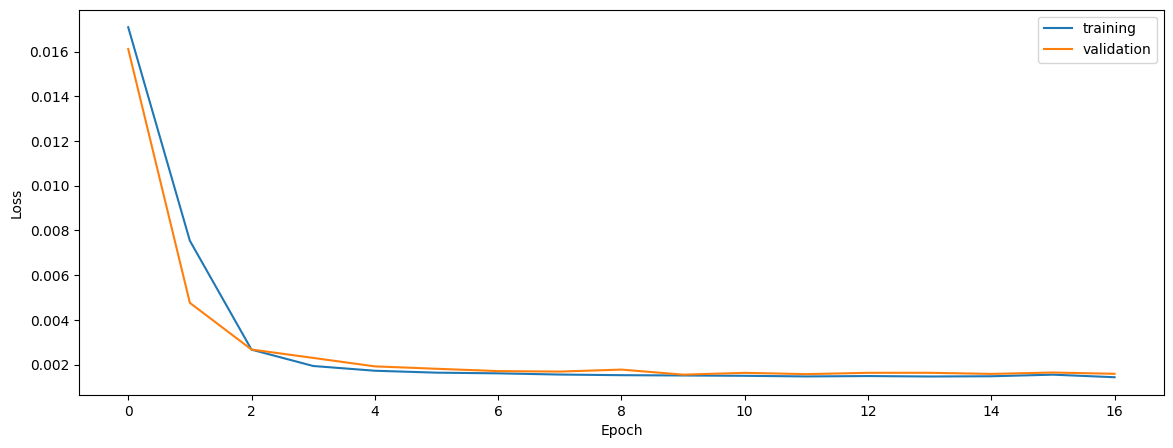

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


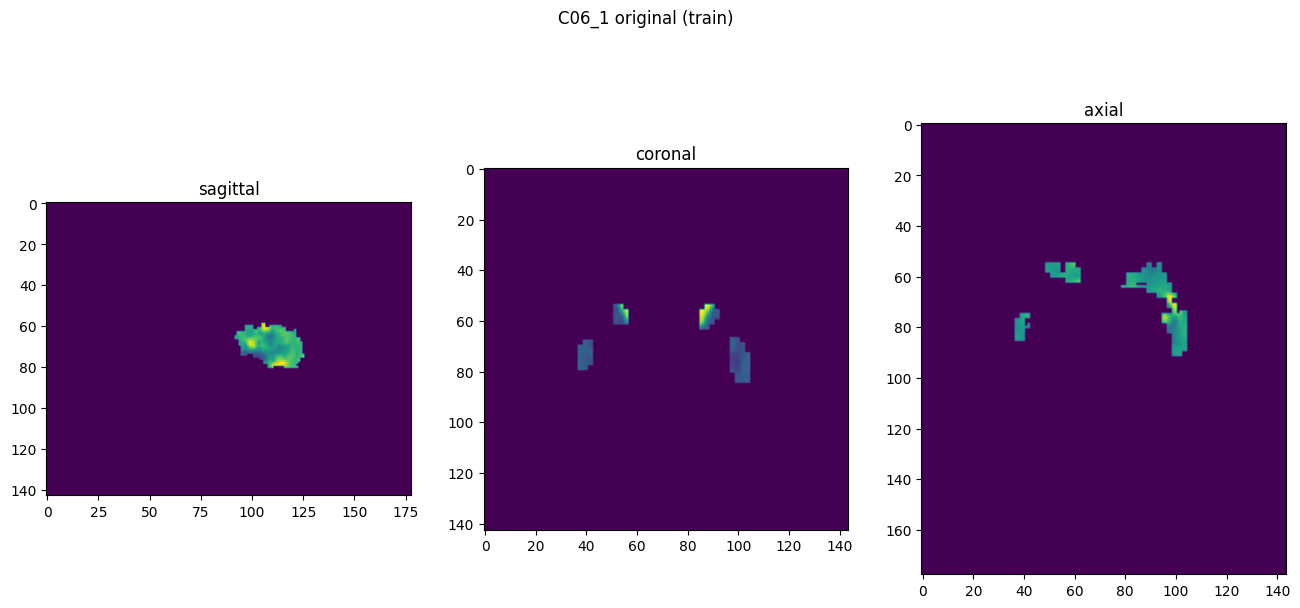

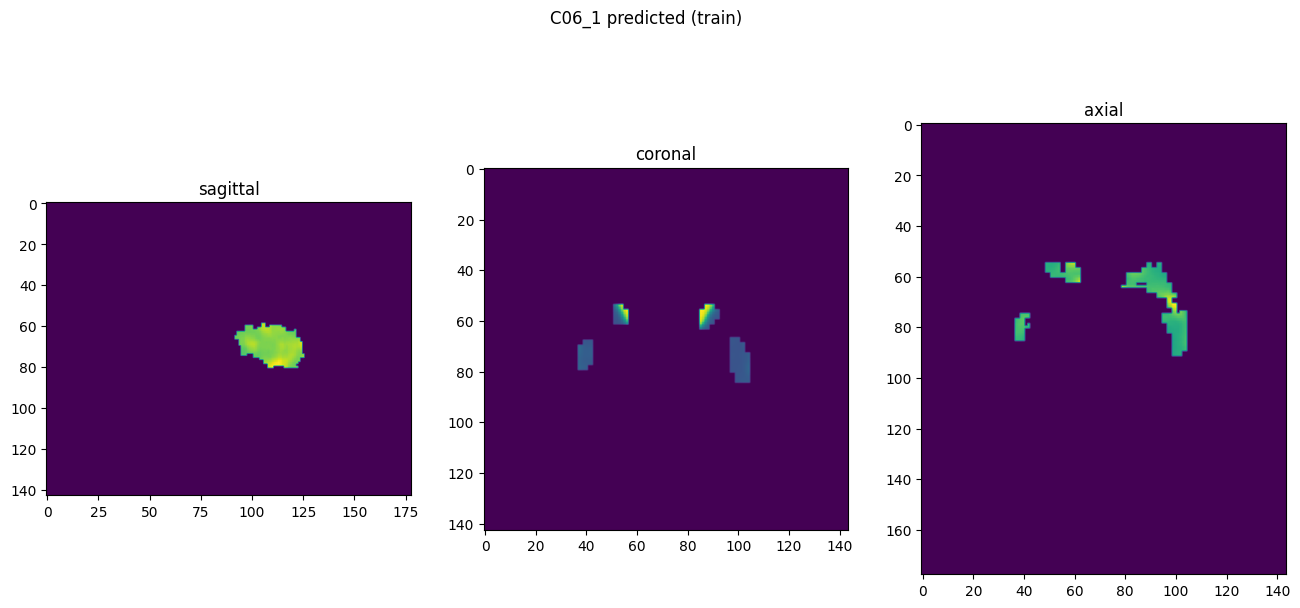

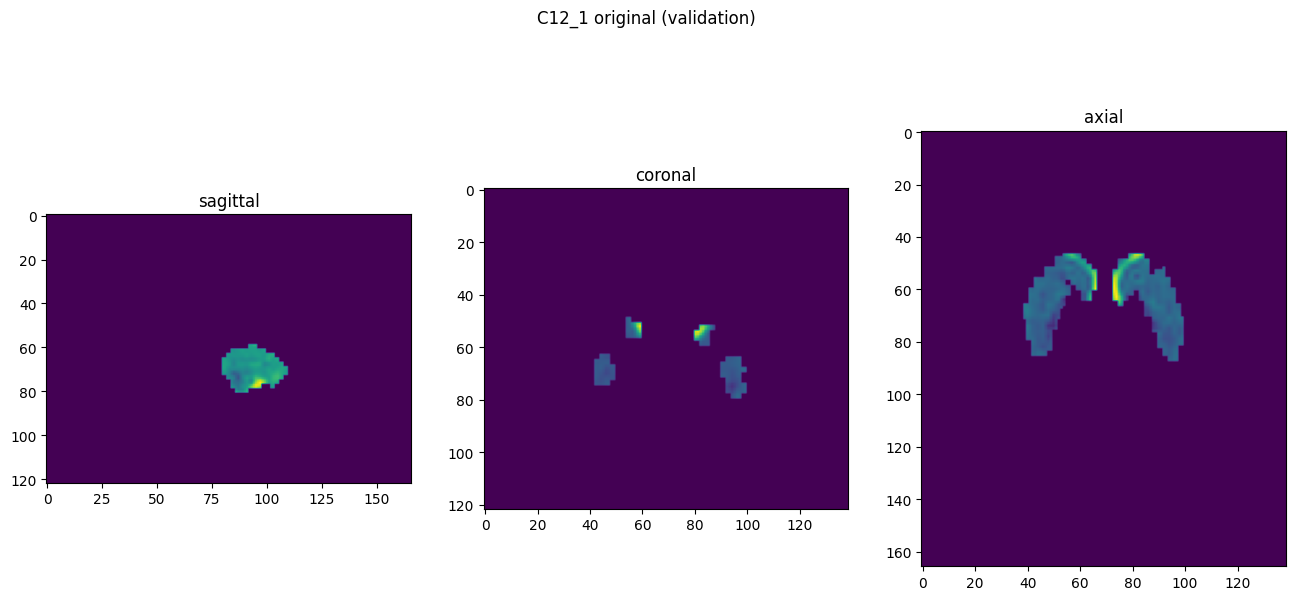

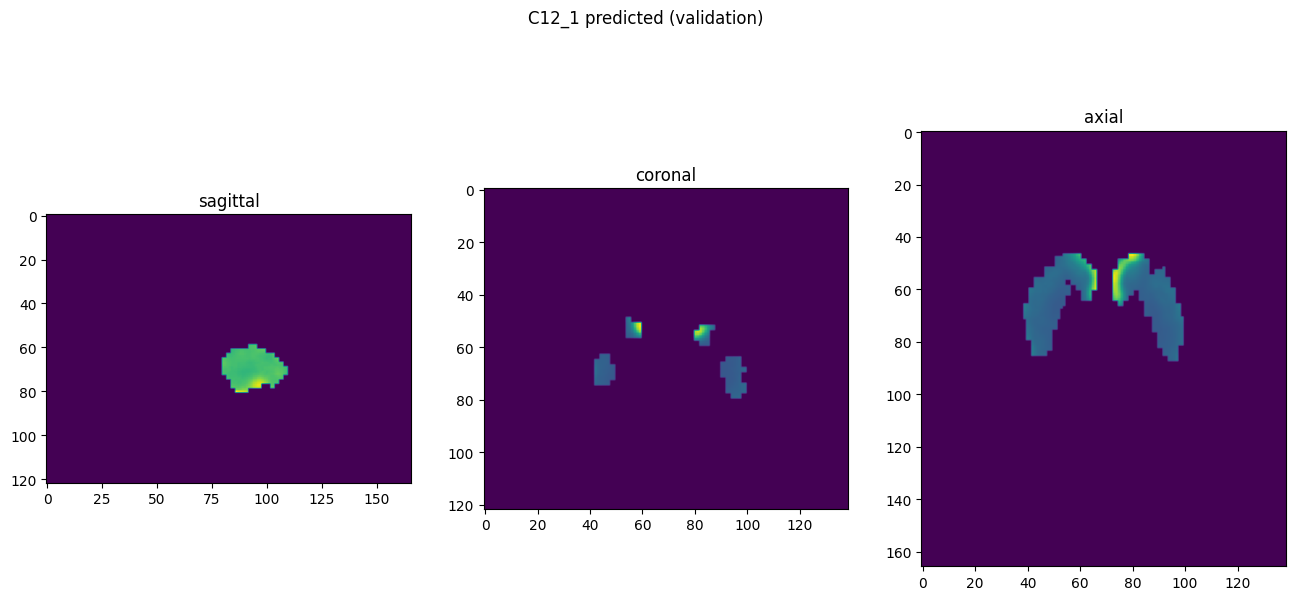

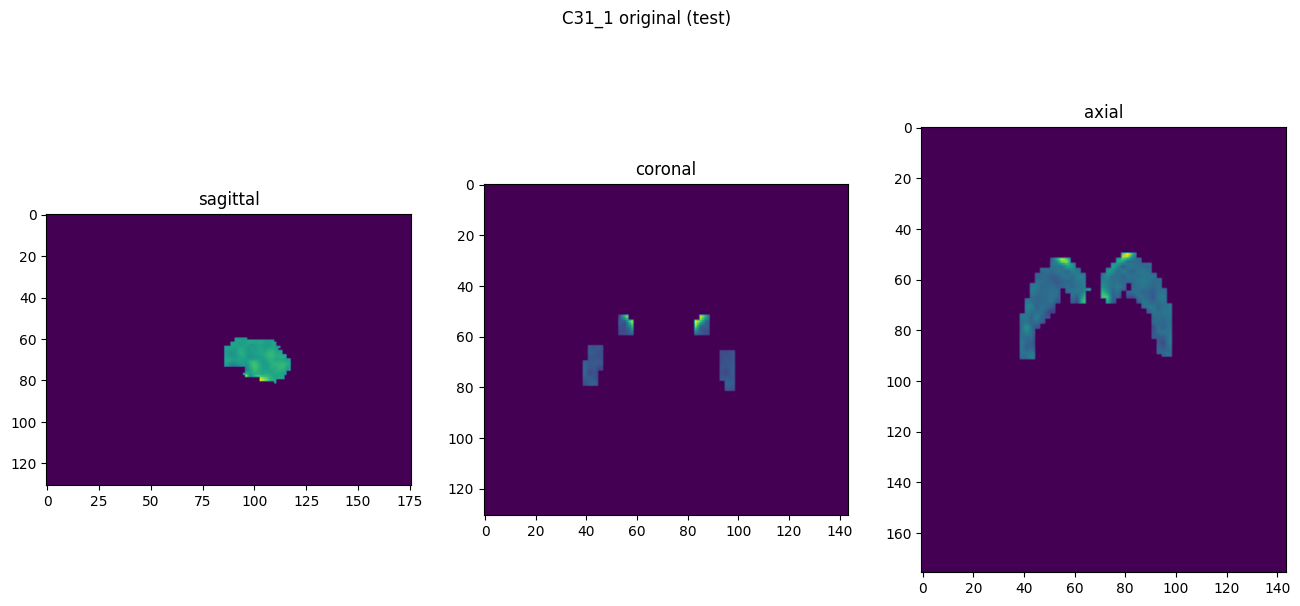

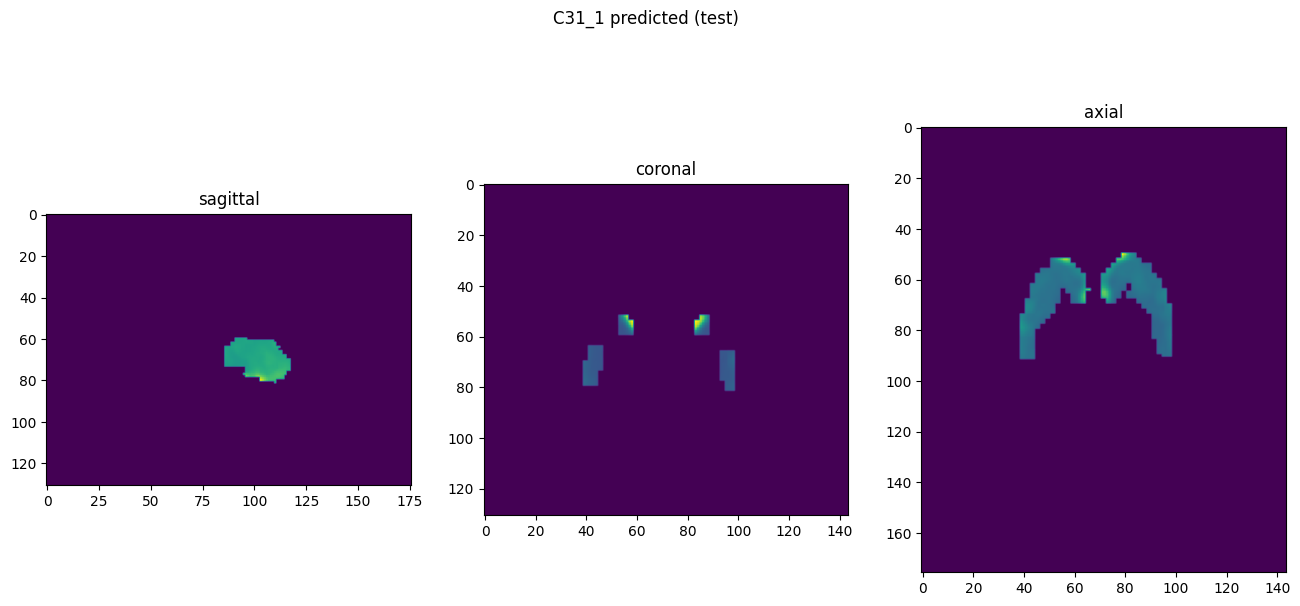

In [10]:
showResults(model, gen, threshold=None, background=False)